In [1]:
!pip install eikonalfm

  Created wheel for eikonalfm: filename=eikonalfm-0.9.5-cp37-cp37m-linux_x86_64.whl size=93329 sha256=3b155e8d5e02530243adc766e55647bd60db7ef25c6368cafe732841319d968b
  Stored in directory: /root/.cache/pip/wheels/e7/3e/c9/d101978dda8f0677a3aab39aab1fbabfb43ff8a89949c790e6
Successfully built eikonalfm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [15]:
dt = 0.001
dx = 20
dz = 20 
x_set = np.arange(0,4000 + dx, dx)
z_set = np.arange(0,2000 + dz, dz)
velocity = np.zeros((len(z_set),len(x_set)))
velocity[:int(500/dz), :] = 2000
velocity[int(500/dz):int(1000 / dz), :] = 3000
velocity[int(1000/dz):int(1500 / dz), :] = 4000
velocity[int(1500/dz):int(2000 +dz / dz), :] = 5000
# for i in range(len(z_set)):
#   if i < 50:
#     velocity[i,:] = 2000
#   elif (i >= 50 and i < 100):
#     velocity[i,:] = 3000
#   elif (i >= 100 and i < 150):
#     velocity[i,:] = 4000
#   elif (i >= 150 and i <= 200):
#     velocity[i,:] = 5000

In [5]:
velocity.shape

(201, 398)

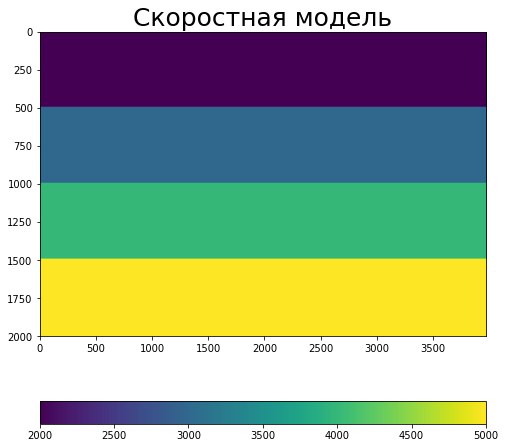

In [6]:
# Скоростная модель
fig = plt.figure(figsize=(8,8))
im = plt.imshow(velocity,
                aspect = 'auto',
                extent = [x_set[0],
                          x_set[-1],
                          z_set[-1],
                          z_set[0]]
               )
plt.title('Скоростная модель',size = 25)
plt.colorbar(im,orientation = 'horizontal')
plt.show()

In [7]:
import eikonalfm

x_s = (0, 1000/dx)# первый индекс z, второй x. Это индексы в массиве координат 
ddx = (1.0, 1.0)
order = 2

tau_fm = eikonalfm.fast_marching(velocity, x_s, ddx, order)

In [8]:
help(eikonalfm.fast_marching)

Help on built-in function fast_marching in module eikonalfm.cfm:

fast_marching(c, x_s, dx, order)
    Calculates the fast marching solution to the eikonal equation.
    
    Parameters
    ----------
    c : ndarray
        (background) velocity array, c(x) > 0.
    x_s : sequence of ints
        Source position as index vector, e.g. ``(0, 0)``. Must have the same length as the number of dimensions of c.
    dx : sequence of doubles
        Grid spacing for each dimension, dx > 0. Must have the same length as the number of dimensions of c.
    order : {1, 2}
        Order of the finite difference operators.
    
    Returns
    ----------
    tau : ndarray
        numerical solution tau for the eikonal equation.



In [9]:
tau_fm.shape

(201, 398)

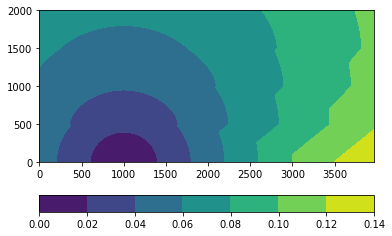

In [10]:
# tau0 = eikonalfm.distance(tau_fm.shape, dx, x_s, indexing="ij") ?  не понял метод
im1 = plt.contourf(( tau_fm), # здесь в скобках может стоять tau0*tau_fm
                 extent = [x_set[0],
                          x_set[-1],
                          z_set[0],
                          z_set[-1]])
plt.colorbar(im1,orientation = 'horizontal')
plt.show();

In [16]:
dx_sou = 20
sources_x = np.arange(0,4000+dx_sou,dx_sou)
input = np.zeros((velocity.shape[0]*velocity.shape[1]*len(sources_x), 3))
observed_time = np.zeros((velocity.shape[0]*velocity.shape[1]*len(sources_x), 1))
# x_set, z_set  
s = 0
for sou in sources_x:
  x_s = (0, int(sou/dx_sou))
  ddx = (1.0, 1.0)
  tau_fm = eikonalfm.fast_marching(velocity, x_s, ddx, 2)
  for j in range(len(z_set)):
    for k in range(len(x_set)):
        input[s] = np.array((sou,z_set[j], x_set[k]))
        observed_time[s] = tau_fm[j,k] 
        s += 1

In [88]:
observed_time[100]

array([0.05])

In [18]:
input.shape

(4080501, 3)

In [19]:
input

array([[   0.,    0.,    0.],
       [   0.,    0.,   20.],
       [   0.,    0.,   40.],
       ...,
       [4000., 2000., 3960.],
       [4000., 2000., 3980.],
       [4000., 2000., 4000.]])

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(input, observed_time, test_size=0.33, random_state=42)

In [22]:
x_train.shape

(2733935, 3)

In [23]:
import tensorflow as tf
# from typing import List, Tuple


# class Residualblock(tf.keras.layers.Layer):
#     def __init__(self,units):
#         super(Residualblock, self).__init__()
#         self.dense_1 = tf.keras.layers.Dense(units, activation='elu')
#         self.dense_2 = tf.keras.layers.Dense(units)
#         self.dense_3 = tf.keras.layers.Dense(units)
#         self.add = tf.keras.layers.Add()

#     def call(self, inputs):
#         x1 = self.dense_1(inputs)
#         x1 = self.dense_2(x1)
#         x2 = self.dense_3(inputs)
#         x3 = self.add((x1,x2))
#         # x3 = tf.keras.layers.ELU(x3)
#         x3 = tf.nn.elu(x3)
#         return x3
# # требует доработки
# class RescaleByCoordinatesLayer(tf.keras.layers.Layer):
#     def __init__(self, offsetScaleList: List[Tuple[float, float]]):
#          super(RescaleByCoordinatesLayer, self).__init__()
#          self.offsetScaleList = offsetScaleList

#     def call(self, inputs):
#         outputs = []
#         for idx, (offset, scale) in enumerate(self.offsetScaleList):
#             outputs.append(input[:, idx]*scale + offset)

#         return tf.transpose(tf.stack(outputs))

In [116]:
class TravelTimesNN(tf.keras.Model):

    def __init__(self, n_denses=6):
        super(TravelTimesNN, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(3,), dtype=tf.float32)
        self.rescaling = tf.keras.layers.Rescaling(scale= 1./np.max(x_set),)
        self.denses = [tf.keras.layers.Dense(50, activation='tanh') for i in range(n_denses)]
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.keras.activations.exponential)

    def call(self, inputs):
        inputs = self.input_layer(inputs)
        inputs = self.rescaling(inputs)
        x = inputs
        for dense in self.denses:
            x = dense(x)
        x = self.output_layer(x)
        norms = tf.math.sqrt(
            tf.math.add(tf.math.square(tf.math.subtract(inputs[:, 0], 
                                                        inputs[:, 2])),
                        tf.math.square(inputs[:, 1])))
        
        outputs = tf.math.multiply(x,
                                   tf.reshape(norms, (-1, 1)))

        return outputs

In [117]:
model = TravelTimesNN(4)

In [93]:
# model = tf.keras.models.Sequential([
#                                     tf.keras.layers.InputLayer(input_shape=(3,)),
#                                     # RescaleByCoordinatesLayer([(2/np.max(x_set),-1.0),(2/np.max(z_set),-1.0),(2/np.max(x_set),-1.0)]),
#                                     tf.keras.layers.Rescaling(scale= 2./np.max(x_set), offset=-1.0,),
#                                     tf.keras.layers.Dense(32, activation='elu'),
#                                     tf.keras.layers.Dense(256, activation='elu'),
#                                     Residualblock(256),
#                                     Residualblock(256),
#                                     # Residualblock(512),
#                                     tf.keras.layers.Dense(256, activation='elu'),
#                                     tf.keras.layers.Dense(32),
#                                     tf.keras.layers.Dense(1)
#                                     ]) 


In [94]:
model.summary()

ValueError: ignored

In [118]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss= tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.mean_squared_error, tf.keras.metrics.mean_absolute_error],)

In [127]:
model.fit(x_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
10680/10680 [==============================] - 46s 4ms/step - loss: 2.3518e-07 - mean_squared_error: 2.3518e-07 - mean_absolute_error: 3.2075e-04
Epoch 2/10
10680/10680 [==============================] - 46s 4ms/step - loss: 2.2627e-07 - mean_squared_error: 2.2627e-07 - mean_absolute_error: 3.1204e-04
Epoch 3/10
10680/10680 [==============================] - 47s 4ms/step - loss: 2.2076e-07 - mean_squared_error: 2.2076e-07 - mean_absolute_error: 3.0760e-04
Epoch 4/10
10680/10680 [==============================] - 46s 4ms/step - loss: 2.1647e-07 - mean_squared_error: 2.1647e-07 - mean_absolute_error: 3.0375e-04
Epoch 5/10
10680/10680 [==============================] - 46s 4ms/step - loss: 2.1340e-07 - mean_squared_error: 2.1340e-07 - mean_absolute_error: 3.0111e-04
Epoch 6/10
10680/10680 [==============================] - 46s 4ms/step - loss: 2.1108e-07 - mean_squared_error: 2.1108e-07 - mean_absolute_error: 2.9894e-04
Epoch 7/10
10680/10680 [==============================] - 

In [131]:
model.evaluate(x_test,  y_test, verbose=1)

42081/42081 [==============================] - 128s 3ms/step - loss: 2.0635e-07 - mean_squared_error: 2.0635e-07 - mean_absolute_error: 2.9383e-04


[2.0634888642234728e-07, 2.0634888642234728e-07, 0.0002938283432740718]

In [129]:
model.predict(np.array([[0,0,2000]]))

array([[0.04996918]], dtype=float32)

In [130]:
path = "/content/gdrive/MyDrive/Colab Notebooks/nn_investigations/EikonalNN.pb"
tf.keras.models.save_model(model,path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/nn_investigations/EikonalNN.pb/assets


In [ ]:
loaded = tf.keras.models.load_model(path)

In [ ]:
loaded.predict(np.array([[0,0,2000]]))